In [23]:
%matplotlib inline  
# Load the libraries
import pickle
import networkx as nx
import glob2, re
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns
from matplotlib import colors as mcolors
from matplotlib.colors import ListedColormap
from collections import Counter

import nbimporter
from Simulation_Analysis_Foraging import CompletionSuccess
from Simulation_Analysis_Foraging import FinishingTimeFirstRobotToCompleteMerkleTree
from Simulation_Analysis_Foraging import CommunicationCostCalculation
from Simulation_Analysis_Foraging import PrivacyCoeff
from Simulation_Analysis_Foraging import unique

# Color palette for figures 

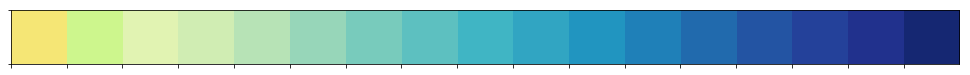

In [7]:
color_map = sns.color_palette("YlGnBu", n_colors=len(ROBOT_RANGE))
color_map = color_map.as_hex()
color_map[0] = '#f5e675'
color_map[1] = '#cdf68d'

#color_map = sns.cubehelix_palette(n_colors=len(ROBOT_RANGE), light=0.7, rot=-0.4)

linestyles = ['-', '--', '-.', ':', '-']
markers=['x', ',', '^', 'o', '.']
loosely_dotted = (0, (5,10))
linestyles = ['solid','dashed','dashdot','dotted',loosely_dotted]
sns.palplot(color_map)

# Maze Formation Finishing Time Functions

In [3]:
def MazeFormationFinishingTimesFirstToCompleteMerkleTree(NUMBER_OF_ROBOTS, NUMBER_OF_TOKENS, THRESHOLD, FILES):
   
    frame = pd.DataFrame()
    csv_columns = []
    sims_set_list = []

    regex = re.compile(r'R' + str(NUMBER_OF_ROBOTS) + '/' + 'T'+ str(NUMBER_OF_TOKENS))
    selected_files = filter(regex.search, FILES) 
        
    # load merkle completed column into dataframe
    for x, file_ in enumerate(selected_files):
        df = pd.read_csv(file_, index_col=None, delimiter='\t', header=0, names=['time','merkle_completed-SIM' + str(x)])
        csv_columns.append(df['merkle_completed-SIM' + str(x)])
        frame = pd.concat(csv_columns,axis=1)
        
    # find the last element of the column
    for x in range(np.size(frame.columns)):
        column_sim_id = 'merkle_completed-SIM' + str(x)
        array_with_nan = frame[column_sim_id].index[frame[column_sim_id].apply(pd.isnull)]
        col_dimension = frame[column_sim_id].count() + 1
        
        # If there is no NaN just check if it is lower than threshold
        if array_with_nan.empty:
            if (col_dimension < THRESHOLD):
                first_robot_timestamp = frame[column_sim_id].index[frame[column_sim_id]>0][0] + 2
                sims_set_list.append(first_robot_timestamp)
            else:
                sims_set_list.append(np.nan)
            
        # If there is NaN just get the first one
        else:
            sims_set_list.append(min(array_with_nan)+1)

    return sims_set_list

In [4]:
def MazeFormationFinishingTimesLastToCompleteMerkleTree(NUMBER_OF_ROBOTS, NUMBER_OF_TOKENS, THRESHOLD, FILES):

    frame = pd.DataFrame()
    csv_columns = []
    sims_set_list = []

    regex = re.compile(r'R' + str(NUMBER_OF_ROBOTS) + '/' + 'T'+ str(NUMBER_OF_TOKENS))
    selected_files = filter(regex.search, FILES) 
        
    # load merkle completed column into dataframe
    for x, file_ in enumerate(selected_files):
        df = pd.read_csv(file_, index_col=None, delimiter='\t', header=0, names=['time','merkle_completed-SIM' + str(x)])
        csv_columns.append(df['merkle_completed-SIM' + str(x)])
        frame = pd.concat(csv_columns,axis=1)
        
    # find the last element of the column
    for x in range(np.size(frame.columns)):
        column_sim_id = 'merkle_completed-SIM' + str(x)
        array_with_nan = frame[column_sim_id].index[frame[column_sim_id].apply(pd.isnull)]
            
        # If there is no NaN just check if it is lower than threshold
        if array_with_nan.empty:
            col_dimension = frame[column_sim_id].count() + 1    
            if (col_dimension < THRESHOLD):
                sims_set_list.append(col_dimension)
            else:
                sims_set_list.append(np.nan)
            
        # If there is NaN just get the first one
        else:
            sims_set_list.append(min(array_with_nan)+1)

    return sims_set_list

In [5]:
# Specify the file paths and the list of all sim data files 
path=r'/home/eddie/maze-formation-epuck-sim/' # use your path
ALL_FILES = glob2.glob(path + "*/*/*/*.dat")

# Filter up to what simulation do you want to consider
SIM_THRESHOLD = 100
for _file in ALL_FILES:
    substring = re.findall(r'SIM\d+', _file)
    current_sim_number = substring[0].strip('SIM')
    if int(current_sim_number) > SIM_THRESHOLD:
        ALL_FILES.remove(_file)

In [6]:
# Specify the search terms for filtering the files
ROBOT_RANGE = range(16,33)
TOKEN_RANGE = range(16,17)
TIMEOUT_THRESHOLD = 5100

# Matrix Creation
FINISHING_TIMES = [[[] for i in range(len(TOKEN_RANGE))] for i in range(len(ROBOT_RANGE))]
SUCCESS_PERCENTAGES = [[[] for i in range(len(TOKEN_RANGE))] for i in range(len(ROBOT_RANGE))]

# Matrix Value Calculation
for x, NUMBER_OF_ROBOTS in enumerate(ROBOT_RANGE):
    for y, NUMBER_OF_TOKENS in enumerate(TOKEN_RANGE):
        FINISHING_TIMES[x][y] = MazeFormationFinishingTimesFirstToCompleteMerkleTree(NUMBER_OF_ROBOTS, NUMBER_OF_TOKENS, TIMEOUT_THRESHOLD, ALL_FILES)       
        SUCCESS_PERCENTAGES[x][y] = CompletionSuccess(TIMEOUT_THRESHOLD, FINISHING_TIMES[x][y])

# Finishing Time Graph

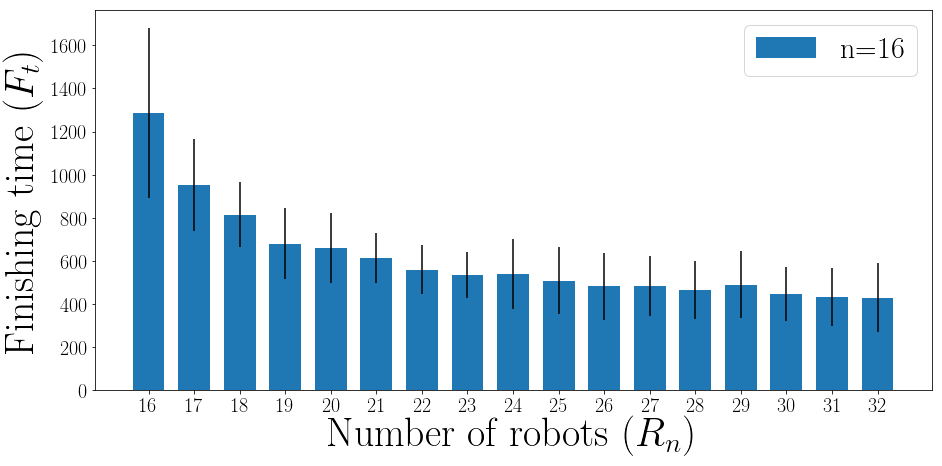

In [8]:
# Finishing Time Calculation
plt.figure(figsize=(15,7))
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

bar_width = 0.7
opacity = 0.4

for y, NUMBER_OF_TOKENS in enumerate(TOKEN_RANGE):
    robot_array =[d2[y] for d2 in [d1[:] for d1 in FINISHING_TIMES]]
    rr = np.array(ROBOT_RANGE)
    plt.bar(rr+(bar_width*y), map(np.nanmean, zip(robot_array)), bar_width, yerr=map(np.nanstd, zip(robot_array)), label='n='+str(NUMBER_OF_TOKENS))
    plt.legend(loc=1, prop={'size': 30})
    
plt.tick_params(labelsize=20)
plt.xticks(rr, ('16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32'))
plt.xlabel('Number of robots' + ' ' +  r'$(R_{n})$' , fontsize=40)
plt.ylabel('Finishing time' + ' ' + r'$(F_{t})$', fontsize=40)
plt.show()

# Probability of Success Graph

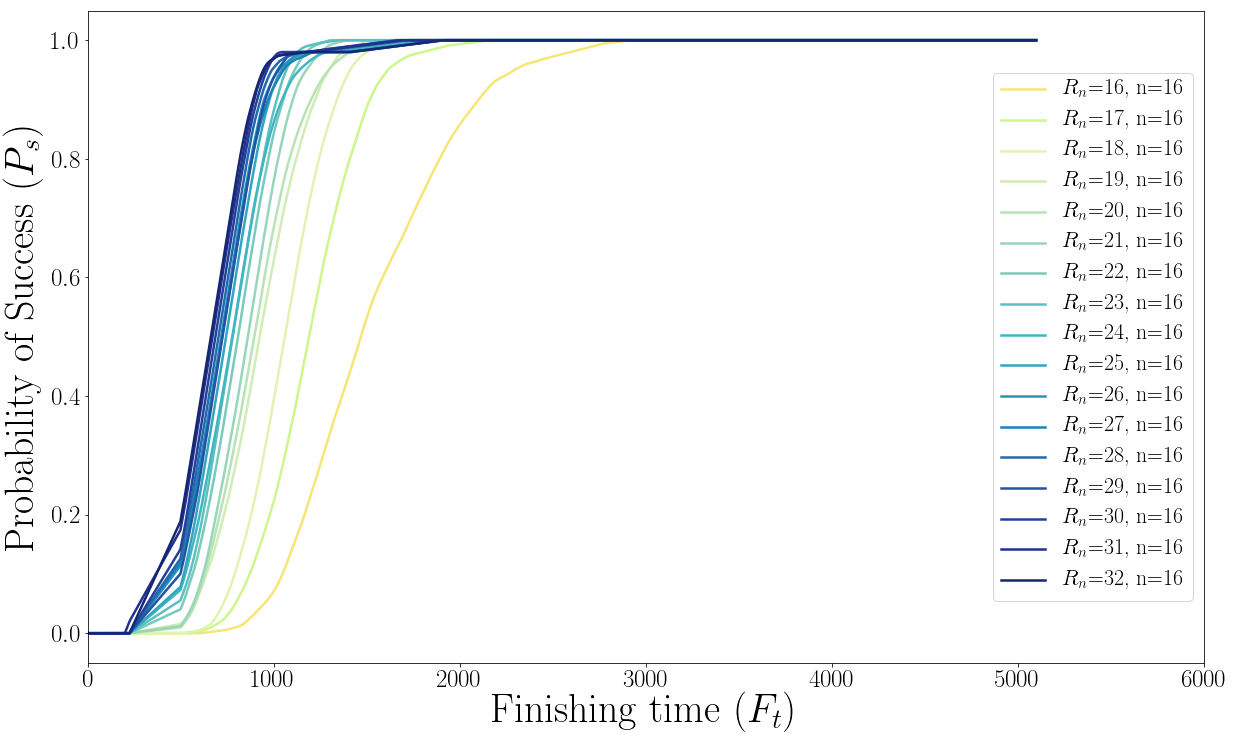

In [9]:
pairs = [(i,j) for i in range(len(ROBOT_RANGE)) for j in range(len(TOKEN_RANGE))]

def interpolate(xnew, pair, SUCCESS_PERCENTAGES):
    xnew[0][225] = SUCCESS_PERCENTAGES[pair[0]][pair[1]][225]
    xnew[0][200] = SUCCESS_PERCENTAGES[pair[0]][pair[1]][200]
    xnew[0][100] = SUCCESS_PERCENTAGES[pair[0]][pair[1]][100]
    xnew[0][0] = SUCCESS_PERCENTAGES[pair[0]][pair[1]][0]
    return xnew

# Success rate calculation
plt.figure(figsize=(20,12))
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

for pair in pairs:
    xnew = pd.DataFrame(SUCCESS_PERCENTAGES[pair[0]][pair[1]]).rolling(500).mean()
    xnew = interpolate(xnew, pair, SUCCESS_PERCENTAGES)
    xnew = xnew.interpolate()
    xnew.dropna(inplace=True)
    #plt.plot(xnew, color=color_map[pair[0]], ls=linestyles[pair[1]], label = "_nolegend")
    plt.plot(xnew, color=color_map[pair[0]], lw=2.5, ls=linestyles[pair[1]], label= str(r'$R_{n}$='+ str(pair[0]+min(ROBOT_RANGE)) + ', n=' + str(pair[1]+min(TOKEN_RANGE))))
    plt.legend(prop={'weight':'bold'})

plt.tick_params(labelsize=25)
plt.xlabel('Finishing time' + ' ' + r'$(F_{t})$', fontsize=40)
plt.ylabel('Probability of Success' + ' ' + r'$(P_{s})$', fontsize=40, fontweight='bold')
plt.xlim([0,6000])
legend_properties = {'size': 22, 'weight': 'bold'}
plt.legend(ncol=1, loc="right", prop=legend_properties)
plt.show()

## Communication Cost and Information diversity

In [10]:
def ExtractCommunicationGraphFirstRobotToCompleteMerkleTree(INITIAL_ID, NUMBER_OF_ROBOTS, NUMBER_OF_LEAVES, SIM_FILE):    
    data = pd.read_json(SIM_FILE)
    time_to_complete_first_merkle = FinishingTimeFirstRobotToCompleteMerkleTree(SIM_FILE, TIMEOUT_THRESHOLD)
    G = nx.DiGraph()
    if not np.isnan(time_to_complete_first_merkle):
        for robotid in xrange(INITIAL_ID, INITIAL_ID + NUMBER_OF_ROBOTS):
            G.add_node(robotid)
            from_robots = data['robots'][time_to_complete_first_merkle-1][robotid - INITIAL_ID]['mk']['from_robot']           
            for other_robot in unique(from_robots):
                G.add_edge(other_robot, robotid, weight=Counter(from_robots)[other_robot])          
    return G

In [11]:
def ExtractCommunicationGraphEndOfExperiment(INITIAL_ID, NUMBER_OF_ROBOTS, NUMBER_OF_LEAVES, SIM_FILE):    
    data = pd.read_json(SIM_FILE)
    rows, columns = data.shape
    G = nx.DiGraph()

    for robotid in xrange(INITIAL_ID, INITIAL_ID + NUMBER_OF_ROBOTS):
        G.add_node(robotid)
        from_robots = data['robots'][rows-1][robotid - INITIAL_ID]['mk']['from_robot']           
        for other_robot in unique(from_robots):
            G.add_edge(other_robot, robotid, weight=Counter(from_robots)[other_robot])          
    return G

In [12]:
def CommunicationCostFirstToCompleteMerkleTreeinKB(INITIAL_ID, NUMBER_OF_ROBOTS, NUMBER_OF_TOKENS, HASH_SIZE_IN_BYTES, FILTERED_FILES):
    CC = []
    GR = []
    for x, file in enumerate(FILTERED_FILES):
        print file
        GR.append(ExtractCommunicationGraphFirstRobotToCompleteMerkleTree(INITIAL_ID, NUMBER_OF_ROBOTS, NUMBER_OF_TOKENS, file))
        CC.append(CommunicationCostCalculation(GR[-1], NUMBER_OF_TOKENS, HASH_SIZE_IN_BYTES)/1024)
    return GR, CC

In [13]:
def CommunicationCostLastToCompleteMerkleTreeinKB(INITIAL_ID, NUMBER_OF_ROBOTS, NUMBER_OF_TOKENS, HASH_SIZE_IN_BYTES, FILTERED_FILES):
    CC = []
    GR = []
    for x, file in enumerate(FILTERED_FILES):
        GR.append(ExtractCommunicationGraphEndOfExperiment(INITIAL_ID, NUMBER_OF_ROBOTS, NUMBER_OF_TOKENS, file))
        CC.append(CommunicationCostCalculation(GR[-1], NUMBER_OF_TOKENS, HASH_SIZE_IN_BYTES)/1024)
    return GR, CC

In [14]:
# Specify the file paths and the list of all sim data files 
ALL_FILES_JSON = glob2.glob(path + "*/*/*/*.json")

# Filter up to what simulation do you want to consider
SIM_THRESHOLD = 50
for _file in ALL_FILES_JSON:
    substring = re.findall(r'SIM\d+', _file)
    current_sim_number = substring[0].strip('SIM')
    if int(current_sim_number) > SIM_THRESHOLD:
        ALL_FILES_JSON.remove(_file)

In [17]:
CC = [[[] for i in range(len(TOKEN_RANGE))] for i in range(len(ROBOT_RANGE))]
GR = [[[] for i in range(len(TOKEN_RANGE))] for i in range(len(ROBOT_RANGE))]
CC2 = [[[] for i in range(len(TOKEN_RANGE))] for i in range(len(ROBOT_RANGE))]
GR2 = [[[] for i in range(len(TOKEN_RANGE))] for i in range(len(ROBOT_RANGE))]
PR = [[[] for i in range(len(TOKEN_RANGE))] for i in range(len(ROBOT_RANGE))]

HASH_SIZE_IN_BYTES = 32
INITIAL_ID = 20

# Matrix Value Calculation
for x, NUMBER_OF_ROBOTS in enumerate(ROBOT_RANGE):
    for y, NUMBER_OF_TOKENS in enumerate(TOKEN_RANGE):     
        regex = re.compile(r'R' + str(NUMBER_OF_ROBOTS) + '/' + 'T'+ str(NUMBER_OF_TOKENS))    
        FILTERED_FILES = filter(regex.search, ALL_FILES_JSON)     
        GR[x][y], CC[x][y] = CommunicationCostFirstToCompleteMerkleTreeinKB(INITIAL_ID, NUMBER_OF_ROBOTS, NUMBER_OF_TOKENS, HASH_SIZE_IN_BYTES, FILTERED_FILES)
        GR2[x][y], CC2[x][y] = CommunicationCostLastToCompleteMerkleTreeinKB(INITIAL_ID, NUMBER_OF_ROBOTS, NUMBER_OF_TOKENS, HASH_SIZE_IN_BYTES, FILTERED_FILES)
        PR[x][y] = PrivacyCoeff(NUMBER_OF_ROBOTS, NUMBER_OF_TOKENS, FILTERED_FILES)

/home/eddie/maze-formation-epuck-sim/R16/T16/SIM30/adjacency_matrix_2020-06-14-23-25-54.json
/home/eddie/maze-formation-epuck-sim/R16/T16/SIM29/adjacency_matrix_2020-06-14-19-06-19.json
/home/eddie/maze-formation-epuck-sim/R16/T16/SIM8/adjacency_matrix_2020-06-08-04-35-43.json
/home/eddie/maze-formation-epuck-sim/R16/T16/SIM36/adjacency_matrix_2020-06-22-15-05-06.json
/home/eddie/maze-formation-epuck-sim/R16/T16/SIM7/adjacency_matrix_2020-06-07-23-30-01.json
/home/eddie/maze-formation-epuck-sim/R16/T16/SIM28/adjacency_matrix_2020-06-14-16-07-39.json
/home/eddie/maze-formation-epuck-sim/R16/T16/SIM4/adjacency_matrix_2020-06-06-13-27-40.json
/home/eddie/maze-formation-epuck-sim/R16/T16/SIM16/adjacency_matrix_2020-06-10-15-22-40.json
/home/eddie/maze-formation-epuck-sim/R16/T16/SIM10/adjacency_matrix_2020-06-09-03-11-22.json
/home/eddie/maze-formation-epuck-sim/R16/T16/SIM39/adjacency_matrix_2020-06-23-08-05-57.json
/home/eddie/maze-formation-epuck-sim/R16/T16/SIM33/adjacency_matrix_2020-

# Communication Cost and information diversity Graph

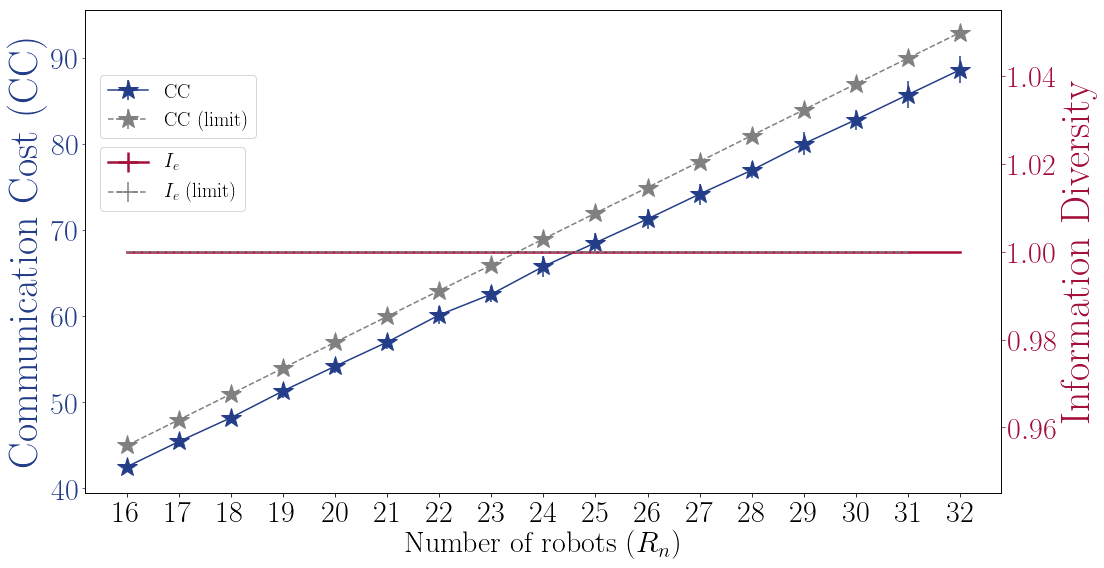

In [18]:
# Communication Cost Vs Information Diversity
fig, ax1 = plt.subplots(figsize=(15,8))

# CC First to complete Merkle tree
robot_row = []
robot_row_std = []

for x, NUMBER_OF_ROBOTS in enumerate(ROBOT_RANGE):
    robot_row.append(np.mean(CC[x]))
    robot_row_std.append(np.std(CC[x]))

ax1.errorbar(ROBOT_RANGE, robot_row, xerr=0, yerr=robot_row_std, marker='*', markersize=20, color='#233D89',label='CC') 
ax1.set_xlabel('Number of robots' + ' ' +  r'$(R_{n})$', fontsize=30)
plt.legend(loc='center left',prop={'size': 20}, bbox_to_anchor=(0.005, 0.80))

# CC Last to complete Merkle tree
robot_row = []
robot_row_std = []

for x, NUMBER_OF_ROBOTS in enumerate(ROBOT_RANGE):
    robot_row.append(np.nanmean(CC2[x]))
    robot_row_std.append(np.nanstd(CC2[x]))

ax1.errorbar(ROBOT_RANGE, robot_row, xerr=0, yerr=robot_row_std, marker='*', ls='dashed', markersize=20, c='grey', label='CC (limit)') 
ax1.set_xlabel('Number of robots' + ' ' +  r'$(R_{n})$', fontsize=30)
plt.legend(loc='center left',prop={'size': 20}, bbox_to_anchor=(0.005, 0.80))


# Make the y-axis label, ticks and tick labels match the line color.
ax1.set_ylabel('Communication Cost (CC)', color='#233D89', fontsize=40)
ax1.tick_params('y', colors='#233D89')
plt.tick_params(labelsize=30)
plt.xticks(tuple((i) for i in ROBOT_RANGE))

ax2 = ax1.twinx()
robot_row = []
robot_row_std = []

for x, NUMBER_OF_ROBOTS in enumerate(ROBOT_RANGE):
    robot_ = [np.nanmean(col) for col in zip(PR[x])]
    robot_row.append(np.nanmean(robot_))
    robot_row_std.append(np.nanstd(robot_))

# Privacy
ax2.errorbar(ROBOT_RANGE, robot_row, xerr=0, yerr=robot_row_std, c='#A4103B', markersize=20, lw=2.5, label=str(r'$I_{e}$')) 

# Limit for Privacy
ax2.errorbar(range(16,32), np.ones(16), xerr=0, yerr=0, c='grey', ls='dashed', markersize=20, label=str(r'$I_{e}$ (limit)')) 
ax2.set_ylabel('Information Diversity', color='#A4103B', fontsize=40)
plt.legend(loc='center left',prop={'size': 20}, bbox_to_anchor=(0.005, 0.65))
ax2.tick_params('y', colors='#A4103B')
fig.tight_layout()
plt.tick_params(labelsize=30)
plt.show()

# Write variables to pickle

In [24]:
with open('SIMULATION_MAZE_FINISHING_TIMES.pickle', 'wb') as f:
    pickle.dump(FINISHING_TIMES, f)
    
with open('SIMULATION_MAZE_COMMUNICATION_COST.pickle', 'wb') as f:
    pickle.dump(CC, f)
    
with open('SIMULATION_MAZE_COMMUNICATION_COST_LIMIT.pickle', 'wb') as f:
    pickle.dump(CC2, f)
        
with open('SIMULATION_MAZE_INFORMATION_DIVERSITY.pickle', 'wb') as f:
    pickle.dump(PR, f)    

# Read from pickle

In [27]:
with open('SIMULATION_MAZE_FINISHING_TIMES.pickle', 'rb') as f:
    FINISHING_TIMES = pickle.load(f)
with open('SIMULATION_MAZE_COMMUNICATION_COST.pickle', 'rb') as f:
    CC = pickle.load(f)
with open('SIMULATION_MAZE_COMMUNICATION_COST_LIMIT.pickle', 'rb') as f:
    CC2 = pickle.load(f)
with open('SIMULATION_MAZE_INFORMATION_DIVERSITY.pickle', 'rb') as f:
    PR = pickle.load(f)    

# Store variables 

In [20]:
SIMULATION_MAZE_FINISHING_TIMES = FINISHING_TIMES
SIMULATION_MAZE_COMMUNICATION_COST = CC
SIMULATION_MAZE_COMMUNICATION_COST_LIMIT = CC2
SIMULATION_MAZE_INFORMATION_DIVERSITY = PR

%store SIMULATION_MAZE_FINISHING_TIMES
%store SIMULATION_MAZE_COMMUNICATION_COST
%store SIMULATION_MAZE_COMMUNICATION_COST_LIMIT
%store SIMULATION_MAZE_INFORMATION_DIVERSITY

Stored 'SIMULATION_MAZE_FINISHING_TIMES' (list)
Stored 'SIMULATION_MAZE_COMMUNICATION_COST' (list)
Stored 'SIMULATION_MAZE_COMMUNICATION_COST_LIMIT' (list)
Stored 'SIMULATION_MAZE_INFORMATION_DIVERSITY' (list)
